In [1]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("yarn").setAppName("WordCount")
sc = SparkContext(conf=conf)

In [2]:
sc.getConf().getAll()

[('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES',
  'http://yarnmaster:8088/proxy/application_1635314650127_0005'),
 ('spark.app.startTime', '1635324879129'),
 ('spark.executorEnv.PYTHONPATH',
  '/usr/local/spark/python:<CPS>{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.9-src.zip'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.heartbeatInterval', '10000000'),
 ('spark.driver.bindAddress', '192.1.1.11'),
 ('spark.ui.port', '4050'),
 ('spark.master', 'yarn'),
 ('spark.ui.proxyBase', '/proxy/application_1635314650127_0005'),
 ('spark.driver.appUIAddress', 'http://edge:4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.yarn.jars', ''),
 ('spark.driver.port', '33705'),
 ('spark.driver.host', 'edge'),
 ('spark.app.name', 'WordCount'),
 ('spark.network.timeout', '10000001'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.yarn.isPython', 'true'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'appli

Working with small text file

In [3]:
lineRDD = (sc
          .textFile("hdfs://yarnmaster:9000/data",8))

This function is for removing special symbols in the rdd
Replace by space because there are some case like he's she'd ...

In [4]:
def removePunctuation(x):
  punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~-’“”‘'
  for ch in punc:
    x = x.replace(ch, ' ')
  return x

Test loader with the first 4 lines

In [5]:
print('\n'.join(lineRDD
               .zipWithIndex()
               .map(lambda t: '{0}: {1}'.format(t[1],t[0]))
               .take(4)))

0: word count from Wikipedia the free encyclopedia
1: the word count is the number of words in a document or passage of text Word counting may be needed when a text
2: is required to stay within certain numbers of words This may particularly be the case in academia legal
3: proceedings journalism and advertising Word count is commonly used by translators to determine the price for


Function to remove stopwords.
I don't care about numbers and some wrong words that contain non alphabet character in it (ex:w0rd, l1ke,...)

In [6]:
def isNotStopWord(word):
    stop_word = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than','st','th','er','ere','']
    if word in stop_word:
        return False
    return True

def removeIllegalWord(word):
    if not char.isalpha():
            word = word.replace(char, "")
    return word

- filteredRDD : This is the Splitting and Preprocessing step 
    + convert to lower case
    + replace special symbols by space
    + split into words
    + remove stopwords
    + remove non alphabet character
    + we only care about word that has more than 1 character -> filter out 1 character words and empty strings
- wordCountRDD: 
    + Map into key,val pairs -> Mapping and shuffling steps
    + Reduce by key and sort -> Reducing steps

In [7]:
import time
start = time.time()
#1. Count the number of times a word appears in the file
filteredRDD = (lineRDD
               .map(lambda x: x.lower())
               .map(removePunctuation)
               .flatMap(lambda x: x.split())
               .filter(isNotStopWord)
               .filter(lambda x: x.isalpha())
               .filter(lambda x: len(x)>1)
              )
wordCountRDD = (filteredRDD
               .map(lambda x: (x,1))
               .reduceByKey(lambda a, b: a +b).sortBy(lambda x: x[0]))
result = wordCountRDD.collect()
num = wordCountRDD.count()
end = time.time()
print("Time processing(s): ", end-start)
print("Number of words: ", num)
print("First word: ", result[0])

Time processing(s):  3.088181972503662
Number of words:  304
First word:  ('abstracts', 1)


Just simply use RDD.max method

In [8]:
#2. Calculate the most common words in the file
import time
start = time.time()
max_ele = wordCountRDD.max(lambda x:x[1])
end = time.time()
print("Time processing(s): ", end-start)
print(max_ele)

Time processing(s):  0.3239006996154785
('word', 28)


Calculate total number of words and divide by number of unique words to get the average

In [9]:
#3. Calculate the average number of appearances of all words.
start = time.time()
from operator import add
uniqueWordCount = wordCountRDD.count()
totalWordCount = wordCountRDD.map(lambda x: x[1]).reduce(add)
totalWordCount/uniqueWordCount
end = time.time()
print("Time processing(s): ", end-start)
print(totalWordCount/uniqueWordCount)

Time processing(s):  0.6520419120788574
1.5986842105263157


In [10]:
#4. Calculate the frequency of combination of two words appears in the text file.
print("Number of words: ",uniqueWordCount)
print("Maximum number of possible combinations: ", uniqueWordCount*uniqueWordCount/2)

Number of words:  304
Maximum number of possible combinations:  46208.0


The number of combinations is only 46208 -> able to solve with rdd.cartesian()

Function to produce result after cartesian.
If 2 words are the same and appear n times -> number of combinations is n*(n-1)/2
Else if 2 words are different and appears n,m times -> number of combinations is n*m

In [11]:
def combinations_func(x):
    if x[0][0] == x[1][0]:
        return (x[0][0],x[1][0],(x[0][1]-1)*x[0][1]/2)
    else:
        return (x[0][0],x[1][0],x[0][1]*x[1][1])

Do the cartesian -> combination function mapping -> filter out the pairs that appeared 0 times.
If a word appears 1 times -> the pair (word, word) will appear 0 times

+ I filter out pair that has x[0][0] <= x[1][0] to avoid duplication, for example: (abc,xyz) and (xyz,abc)

In [12]:
start = time.time()
combineRDD = (wordCountRDD.cartesian(wordCountRDD).filter(lambda x: x[0][0] <= x[1][0]).map(combinations_func).filter(lambda x: x[2]>0))
result = combineRDD.collect()
num = combineRDD.count()
end = time.time()
print("Time processing(s): ", end-start)
print("Number of combinations: ", num)
print("First pair: ", result[0])

Time processing(s):  23.13502335548401
Number of combinations:  46124
First pair:  ('abstracts', 'academia', 1)


+ Sort by number of appearances
+ The median pos is the middle position (there may be 2 but for default I will take only one)
+ Convert the sorted rdd to list and the elements at median pos is the result 

In [13]:
#5. Print the two combined words that are the median in term of number of the appearances.
start = time.time()
sortCombineRDD = combineRDD.sortBy(lambda x: x[2])
median_pos = sortCombineRDD.count()/2
result = (sortCombineRDD.collect())[int(median_pos)]
end = time.time()
print("Time processing(s): ", end-start)
print(result)

Time processing(s):  36.370278120040894
('feature', 'typing', 1)


#WORKING WITH BIG FILE (1.1GB)
The step is the same from question 1->question 3. In the question 4, I tried to imitate the triagular matrix

####
I DON'T RUN THIS AGAIN BECAUSE IT'S TOO EXPENSIVE TO RUN

The big file in in data_big folder

In [14]:
# lineRDD = (sc
#           .textFile("hdfs://yarnmaster:9000/data_big",8))

The word count processing is pretty much the same with above.
However, I see that there are lot of error words and meanningless word that we are not interested in
So I filter out the word that has more than 15 letters.

There are many word that not in ascii. However when we sort the RDD, they will be at bottom of the list. So we just need to discard some words at the bottom. (I don't do the remove because they make up very low percentage of the list)

I also tried to choose words that in dictionary using nltk. But that is too slow and too many useful words are discarded. So I have no way to solve this.




In [15]:
# import time
# start = time.time()
# #1. Count the number of times a word appears in the file
# filteredRDD = (lineRDD
#                .map(lambda x: x.lower())
#                .map(removePunctuation)
#                .flatMap(lambda x: x.split())
#                .filter(isNotStopWord)
#                .filter(lambda x: x.isalpha())
#                .filter(lambda x: len(x)>1 and len(x)<15)
#               )
# wordCountRDD = (filteredRDD
#                .map(lambda x: (x,1))
#                .reduceByKey(lambda a, b: a +b).sortBy(lambda x: x[0]))
# result = wordCountRDD.collect()
# num = wordCountRDD.count()
# end = time.time()
# print("Time processing(s): ", end-start)
# print("Number of words: ", num)
# print("First word: ", result[0])

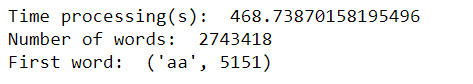

In [16]:
# print("The last words that doesn't contain non ascii character:", result[2735987])
# print('Next word is:'result[2735988])

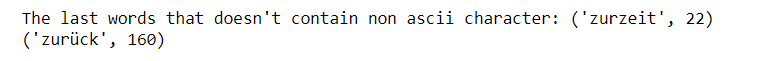

Because the number of words is too huge. I map the result array into a new RDD.

In [17]:
# freqRDD = sc.parallelize(result, 8)

In [18]:
# # 2. Calculate the most common words in the file
# import time
# start = time.time()
# max_ele = freqRDD.max(lambda x:x[1])
# end = time.time()
# print("Time processing(s): ", end-start)
# print(max_ele)

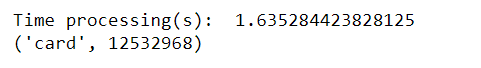

In [19]:
# # 3. Calculate the average number of appearances of all words.
# start = time.time()
# from operator import add
# uniqueWordCount = freqRDD.count()
# totalWordCount = freqRDD.map(lambda x: x[1]).reduce(add)
# totalWordCount/uniqueWordCount
# end = time.time()
# print("Time processing(s): ", end-start)
# print(totalWordCount/uniqueWordCount)

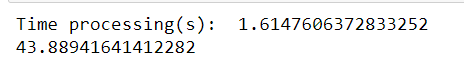

In [21]:
# 4. Calculate the frequency of combination of two words appears in the text file
# print("Number of words: ",uniqueWordCount)
# print("Maximun number of possible combinations: ", uniqueWordCount*uniqueWordCount/2)

There are over 3.7 thousand billions combinations -> there is no way cartesian can solve this

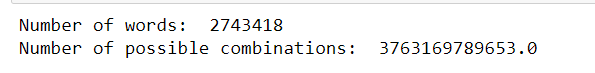
As I see that most of the words that appears only 1 times is not very useful and they make up large percentage -> So we can try remove it to reduce the combination.

In [22]:
# uselessWord = freqRDD.filter(lambda x: x[1]>1).count()
# print("Number of words: ", uselessWord)
# print("Number of possible combinations: ", uselessWord*uselessWord/2)

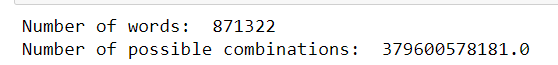

We can see that the number of combinations reduced by 10 times. That is more doable.

The method I do to solve this is:
+ Map sorted by key (key,val) list to (val) list => I see that the order remains so I think this is ok.
+ Saved (val) list into freq
+ Create RDD of n(n-1)/2 elements
+ We do mapping on new RDD that x = freq[i] * freq[j] or freq[i] * (freq[i]-1)/2 (with i = x/uniqueWordCount, j = x%uniqueWordCount)

In [73]:
# def map_func(x):
#     i = int(x/uniqueWordCount)
#     j = x%uniqueWordCount
#     if i == j:
#         x = freq[i]*(freq[i]-1)/2
#     else:
#         x = freq[i] * freq[j]
#     return x

In [72]:
# combRDD =  freqRDD.map(lambda x: x[1]).filter(lambda x: x>1)
# uniqueWordCount = combRDD.count()
# numCombinations = int(uniqueWordCount/2)*(uniqueWordCount+1)
# combination = range(0,numCombinations) # new list of numCombinations elements
# combinationRDD = sc.parallelize(combination,8)  # convert to RDD
# freq = combRDD.collect() # Freq list
# print("freq[0]=",freq[0])

freq[0]= 5151


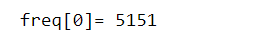

In [74]:
# start = time.time()
# result = combinationRDD.map(map_func).collect()
# end = time.time()
# print("Time processing(s): ", end-start)
# print(result[0])

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 73.0 failed 4 times, most recent failure: Lost task 0.3 in stage 73.0 (TID 780, yarnslave2, executor 6): ExecutorLostFailure (executor 6 exited caused by one of the running tasks) Reason: Container from a bad node: container_1635314650127_0004_02_000003 on host: yarnslave2. Exit status: 143. Diagnostics: [2021-10-27 08:52:26.773]Container killed on request. Exit code is 143
[2021-10-27 08:52:26.773]Container exited with a non-zero exit code 143. 
[2021-10-27 08:52:26.775]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2008)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2007)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2007)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:973)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:973)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2239)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2188)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2177)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:775)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2114)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2135)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2154)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2179)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1004)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:388)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1003)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:168)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor42.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


I've got memory problem on this and unable to get result. But I think this will work ok if I have better machine.

#5. Print the two combined words that are the median in term of number of the appearances.
It is easy if we only find the median of words that appear more than 1 times -> It is the same with small file.
If we want to obtain all words, I think it would relate to some math.

We have list count of over 370 billions and there are remained about 3330 billions combinations we haven't calculated.
+ 2 words appeared one time -> appear 1 time. (= 1872096*1872095/2 combs)
+ 1 words appeared 1 time and other appeared n -> appear n times. (1872096*871322 combs)
....